In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import SCORERS
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('ASCP_data.csv')

In [3]:
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [4]:
df.shape

(200, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newspaper   200 non-null    float64
 4   sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


 - No missing values
 - 200 rows of data
 - 4 data columns and one index column

In [6]:
df.describe()

,Unnamed: 0,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


Basic stat info of df

In [7]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

 - Dropping index column

In [8]:
df

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


<AxesSubplot:>

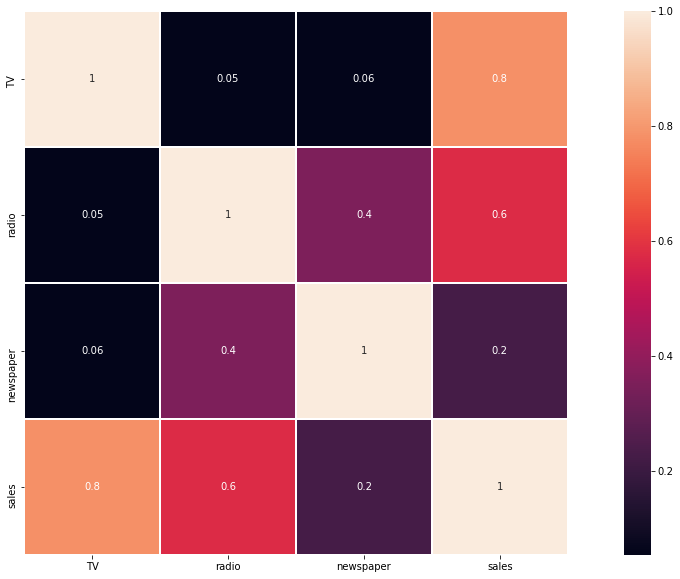

In [9]:
df_corr=df.corr().abs()
plt.figure(figsize=(20,10))
sns.heatmap(df_corr,annot=True,square=True,fmt='.1g',linewidth=1)

 - correlation between columns
 - multi collinearity not present so no need to drop columns

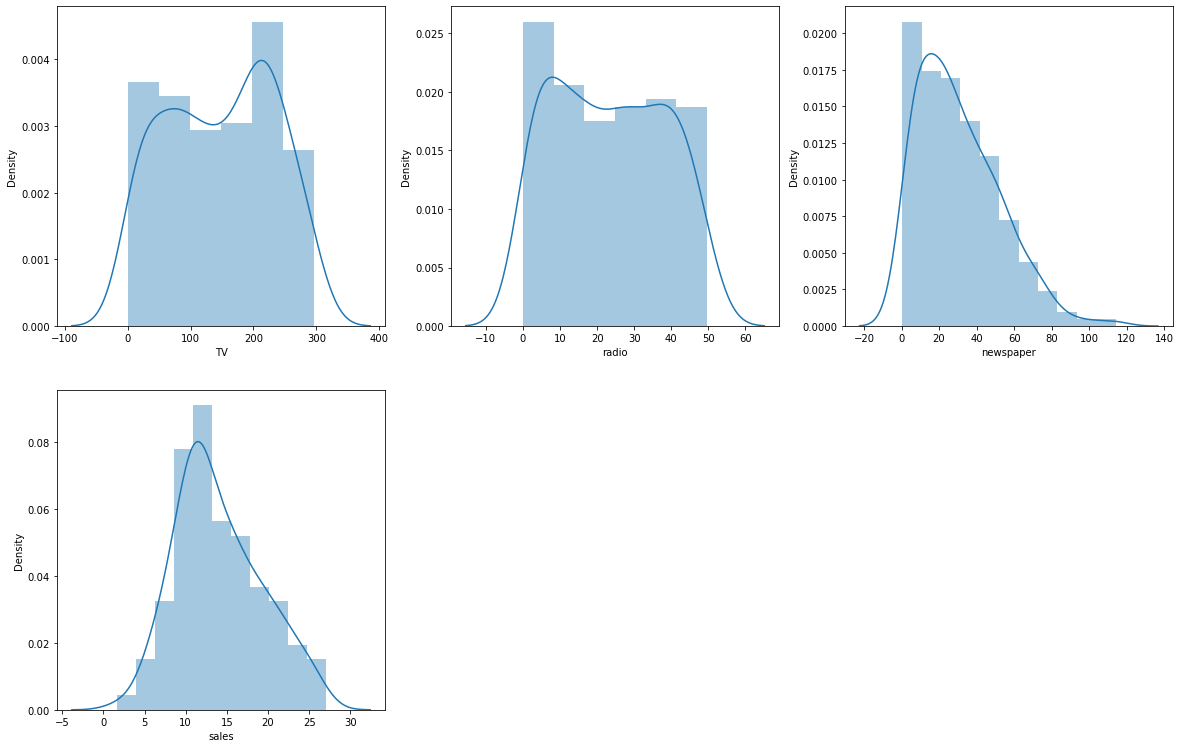

In [10]:
#Distribution of the df
plt.figure(figsize=(20,20),facecolor='white')
plotnumber=1
for i in df:
    if plotnumber<=9:
        ax=plt.subplot(3,3,plotnumber)
        sns.distplot(df[i])
        plt.xlabel(i)
    plotnumber+=1

 - There is some skew in our data(eg: newspaper, sales)

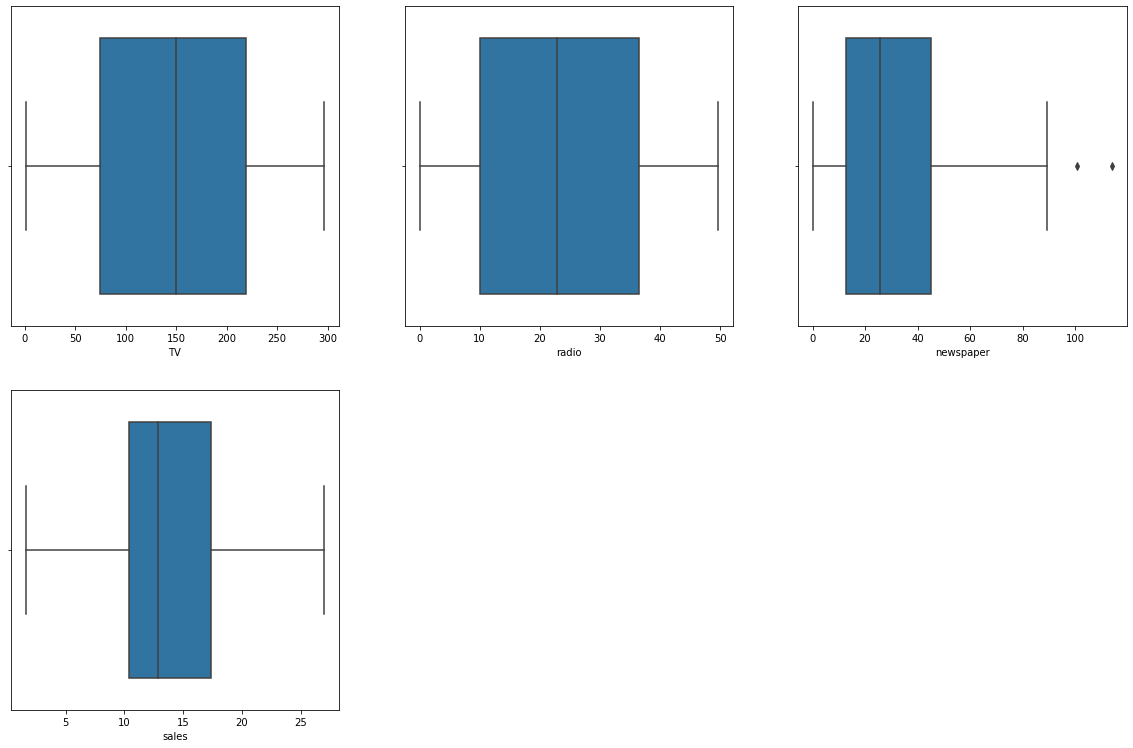

In [11]:
plt.figure(figsize=(20,20))
plotnumber=1
for i in df:
    if plotnumber<=9:
        ax=plt.subplot(3,3,plotnumber)
        sns.boxplot(df[i])
        plt.xlabel(i)
    plotnumber+=1

 - Df consists of some outliers(lf newspaper)

In [12]:
#Removing outliers using zscore
z=np.abs(stats.zscore(df))
np.where(z>3)

(array([ 16, 101]), array([2, 2]))

In [13]:
index=(np.where(z>3)[0])
df=df.drop(df.index[index])

In [14]:
df.shape

(198, 4)

 - 2 rows dropped (200 - 198)

In [15]:
df.skew()

TV          -0.082332
radio        0.114842
newspaper    0.650112
sales        0.407130
dtype: float64

In [16]:
# Separating features and Labels
X = df.drop('sales',axis=1) 
y = df['sales']

In [17]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_new = power.fit_transform(X)

In [18]:
data_new=pd.DataFrame(data_new,columns=X.columns)
data_new.skew()

TV          -0.320682
radio       -0.236668
newspaper   -0.101288
dtype: float64

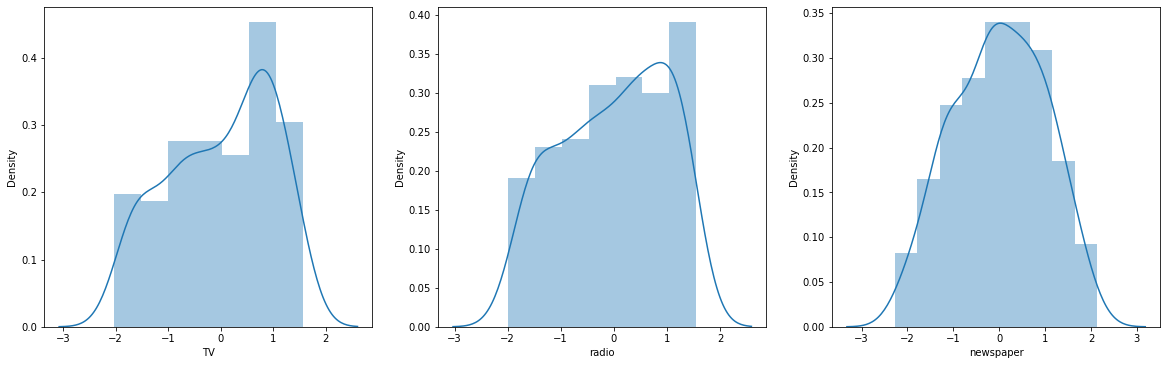

In [19]:
plt.figure(figsize=(20,20),facecolor='white')
plotnumber=1
for i in data_new:
    if plotnumber<=9:
        ax=plt.subplot(3,3,plotnumber)
        sns.distplot(data_new[i])
        plt.xlabel(i)
    plotnumber+=1

In [20]:
X = data_new
scaler=StandardScaler()
X=scaler.fit_transform(X)

### Model

In [21]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 15% |  5% |


In [22]:
min_squared_error = 0
max_random_state = 0
for i in range(1,200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    model=XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    model.fit(X_train,y_train)
    pred= model.predict(X_test)
    root_mean_squared_error=np.sqrt(mean_squared_error(y_test,pred))
    if root_mean_squared_error<min_squared_error:
        min_squared_error=root_mean_squared_error
        max_random_state=i
        
print('lowest error is: ',min_squared_error,' on random_state ',max_random_state)

lowest error is:  0  on random_state  0


In [23]:
en = ElasticNet()
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=0)
ar = AdaBoostRegressor(random_state=0)
gbr= GradientBoostingRegressor(random_state=0)
sr = SVR()
lgr=LGBMRegressor(random_state=0)
xgbr = XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state = 0)

m_list= [en,dtr,rfr,ar,gbr,sr,lgr,xgbr]

s=SCORERS
s.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [24]:
#seperating the training data and test data:-
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
for m in m_list:
    m.fit(X_train,y_train)
    preds = m.predict(X_test)
    rmse= np.sqrt(mean_squared_error(y_test,preds))
    print(m)
    print('Root_mean_squared_error: ',rmse)
    print('cross validation scores below:--  \n',m)
    print('root_mean_squared_error: ',cross_val_score(m,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
    print('difference between model score and cross validation score: ',-rmse-cross_val_score(m,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
    print('\n')
    print('\n')

ElasticNet()
Root_mean_squared_error:  2.8539361336518114
cross validation scores below:--  
 ElasticNet()
root_mean_squared_error:  -2.6265608521172483
difference between model score and cross validation score:  -0.2273752815345631




DecisionTreeRegressor(random_state=0)
Root_mean_squared_error:  1.0200490184299968
cross validation scores below:--  
 DecisionTreeRegressor(random_state=0)
root_mean_squared_error:  -1.1450220736386723
difference between model score and cross validation score:  0.12497305520867541




RandomForestRegressor(random_state=0)
Root_mean_squared_error:  0.7835378846403431
cross validation scores below:--  
 RandomForestRegressor(random_state=0)
root_mean_squared_error:  -0.779512929168187
difference between model score and cross validation score:  -0.004024955472156089




AdaBoostRegressor(random_state=0)
Root_mean_squared_error:  1.0030795710891272
cross validation scores below:--  
 AdaBoostRegressor(random_state=0)
root_mean_squared_error:  -1.0739843067

 - Random forest regressor has least difference between model score and cross validation score

### HPT

In [26]:
grid_param = {'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)],
              'max_features':['auto','log2','sqrt'],
              'max_depth':[int(x) for x in np.linspace(5, 30, num = 6)],
              'bootstrap':[True, False]}

In [27]:
grid_search=GridSearchCV(RandomForestRegressor(random_state=0),param_grid=grid_param,cv=5,n_jobs=-1,verbose = 2,scoring='neg_root_mean_squared_error')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000, 1100, 1200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [28]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 700}

In [29]:
# Fitting model with best params
m = RandomForestRegressor(random_state=0,bootstrap=True,max_depth=10,max_features='auto',n_estimators=700)
m.fit(X_train,y_train)
preds = m.predict(X_test)
rmse= np.sqrt(mean_squared_error(y_test,preds))
print(m)
print('Root_mean_squared_error: ',rmse)
print('cross validation scores below:--  \n',m)
print('root_mean_squared_error: ',cross_val_score(m,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('difference between model score and cross validation score: ',-rmse-cross_val_score(m,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())

RandomForestRegressor(max_depth=10, n_estimators=700, random_state=0)
Root_mean_squared_error:  0.7793488518237462
cross validation scores below:--  
 RandomForestRegressor(max_depth=10, n_estimators=700, random_state=0)
root_mean_squared_error:  -0.7788603717998186
difference between model score and cross validation score:  -0.000488480023927651


### Model Saving

In [30]:
import joblib

joblib.dump(m,'gradient_boosting_regressor_best.obj')

['gradient_boosting_regressor_best.obj']

In [31]:
joblib.load('gradient_boosting_regressor_best.obj')

RandomForestRegressor(max_depth=10, n_estimators=700, random_state=0)